<a href="https://colab.research.google.com/github/mnassar/segfault/blob/main/SegFault_TABLE_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection Accuracy after Attack for one random batch of 128 images 
# TABLE I

install foolbox and libraries


In [ ]:
!pip install foolbox

In [ ]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import numpy as np
import foolbox as fb
import matplotlib.pyplot as plt

get the classifier


In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H4KEE0Vp8DFZOe_QfcxqOxEVnpun-uka' -O CIFAR10model.h5

--2021-05-26 02:34:47--  https://docs.google.com/uc?export=download&id=1H4KEE0Vp8DFZOe_QfcxqOxEVnpun-uka
Resolving docs.google.com (docs.google.com)... 74.125.199.113, 74.125.199.139, 74.125.199.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.199.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mqgcmgm7urdjq4tkm0esr9k6uva1prm7/1621996425000/13345485370729250143/*/1H4KEE0Vp8DFZOe_QfcxqOxEVnpun-uka?e=download [following]
--2021-05-26 02:34:48--  https://doc-0s-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mqgcmgm7urdjq4tkm0esr9k6uva1prm7/1621996425000/13345485370729250143/*/1H4KEE0Vp8DFZOe_QfcxqOxEVnpun-uka?e=download
Resolving doc-0s-68-docs.googleusercontent.com (doc-0s-68-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0s-68-docs.googleusercontent.com (doc-0s-68-d

load the classifier

In [ ]:
# load the cifar classifier
from tensorflow.keras.models import load_model

pretrained_model = load_model('CIFAR10model.h5')
pretrained_model.trainable = False
pretrained_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

get the dataset

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print (ds_info)


tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



In [ ]:
# normalize images 

# these are the numbers used during training the model 
mean = 120.70748
std = 64.150024
bound_min = (0-mean)/std
bound_max = (255-mean)/std

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  # return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10)
  return (tf.cast(image, tf.float32) - mean) / std, tf.one_hot(label, 10)


ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# fix the batch to work with
images, labels = next(iter(ds_train))
# accuracy before attack
pretrained_model.evaluate(images,labels)

4/4 [==============================] - 1s 6ms/step - loss: 0.3866 - accuracy: 0.9453


[0.3866119086742401, 0.9453125]

C & W Attack

In [ ]:
%%time 
# epsilons = [0.02, 0.06, 0.1]
epsilons = None
labels_class = tf.argmax(labels, axis=1)
fmodel = fb.models.TensorFlowModel(model=pretrained_model, bounds=(bound_min, bound_max))
attack = fb.attacks.L2CarliniWagnerAttack(steps=500)
raw, fimages, is_adv = attack(fmodel, images, criterion=fb.criteria.Misclassification(labels_class),epsilons=epsilons)


CPU times: user 21.5 s, sys: 398 ms, total: 21.8 s
Wall time: 21.6 s


In [ ]:
# for eps, fimages_single in zip(epsilons, fimages): 
  # print("for eps=", eps)
  # fpreds = pretrained_model.predict(fimages_single)
pretrained_model.evaluate(fimages_single,labels)

4/4 [==============================] - 0s 5ms/step - loss: 1.0999 - accuracy: 0.1719


[1.099870204925537, 0.171875]

In [ ]:
# print (len(fimages[2]))
# print (len(images))
# print (is_adv)
# print (fpreds.shape)
fimages[0][0].shape 

TensorShape([32, 32, 3])

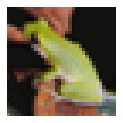

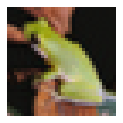

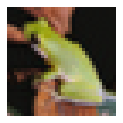

In [ ]:
# raw vs. fimage: (we use fimage as suggested in https://foolbox.jonasrauber.de/guide/getting-started.html#attacking-the-model)
import matplotlib.pyplot as plt
plt.figure(figsize = (2,2))
plt.axis('off')
plt.imshow((images[2].numpy() * std + mean).astype(np.uint8))
plt.show()

plt.figure(figsize = (2,2))
plt.axis('off')
plt.imshow((fimages[2].numpy() * std + mean).astype(np.uint8))
plt.show()

plt.figure(figsize = (2,2))
plt.axis('off')
plt.imshow((raw[2].numpy() * std + mean).astype(np.uint8))
plt.show()

PGD, FGSM, LinfDeeoFool Attack


In [ ]:
attacks = [fb.attacks.FGSM(), fb.attacks.PGD(), fb.attacks.LinfDeepFoolAttack()]
for attack in attacks: 
  raw, fimages, is_adv = attack(fmodel, images, criterion=fb.criteria.Misclassification(labels_class),epsilons=epsilons)
  for eps, fimages_single in zip(epsilons, fimages): 
    print(attack, " for eps=", eps)
    # fpreds = pretrained_model.predict(fimages_single)
    pretrained_model.evaluate(fimages_single,labels)



LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)  for eps= 0.02
4/4 [==============================] - 0s 5ms/step - loss: 3.0451 - accuracy: 0.3672
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)  for eps= 0.06
4/4 [==============================] - 0s 5ms/step - loss: 6.8221 - accuracy: 0.1328
LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)  for eps= 0.1
4/4 [==============================] - 0s 5ms/step - loss: 7.4315 - accuracy: 0.0547
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)  for eps= 0.02
4/4 [==============================] - 0s 5ms/step - loss: 4.0958 - accuracy: 0.2734
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)  for eps= 0.06
4/4 [==============================] - 0s 5ms/step - loss: 16.8985 - accuracy: 0.0078

In [ ]:
print("Done!")

Done!
